# Genetic Algorithm NeuroEvolution
Evolving the weights of a fixed Neural Controller using Genetic Algorithm

In [61]:
import importlib
import environment 
import neural_controller
import utils
importlib.reload(environment)
importlib.reload(neural_controller)
importlib.reload(utils)

import numpy as np
import random
from deap import base, cma, creator, tools, algorithms

In [62]:
initial_setting = {
   'agents': np.array([[0, 5], [0, 10], [0, 15]], dtype=float),
   'blocks': np.array([[9, 16], [10, 12], [11, 6]], dtype=float),
   'colors': np.array([environment.RED, environment.GREEN, environment.RED], dtype=int)
}

env = environment.Environment(objective = [(environment.RED, environment.NORTH_EDGE)],
                   size = environment.SIMULATION_ARENA_SIZE, 
                   n_agents = 3, 
                   n_blocks = 3,
                   n_neighbors = 3,
                   sensor_range = environment.SIMULATION_SENSOR_RANGE,
                   sensor_angle = 360,
                   max_distance_covered_per_step = environment.SIMULATION_MAX_DISTANCE,
                   sensitivity = 0.2,
                   initial_setting = initial_setting)
env.reset(seed = 12)
env.print_env()

. . . . . . 0 . . . . . . 1 . . . . . 2 . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . O . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . O . . . . . . . . .
. . . . . . . . O . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .


In [63]:
input_dim = (env.n_types + 2) * env.n_neighbors + env.n_types - 2
output_dim = 2
hidden_units = [16]
layer_sizes = [input_dim] + hidden_units + [output_dim]

nn = neural_controller.NeuralController(layer_sizes, hidden_activation="sigmoid", output_activation="sigmoid")
nn.summary()

NeuralController with layer sizes:  [44, 16, 2]
Total weights: 754, not set


In [64]:
def calculate_fitness(individual, n_steps=100, verbose = False):
        
    fitness = 0
    obs, _ = env.reset()
    
    # Set the weights of the network
    nn.set_weights_from_vector(individual)

    for step in range(n_steps):
        
        nn_inputs = env.process_observation(obs)
        nn_outputs = np.array(nn.predict(nn_inputs))
        actions = np.round(nn_outputs * np.array([env.max_distance_covered_per_step, env.sensor_angle]), 1)
            
        obs, reward, done, _, _ = env.step(actions)

        fitness += reward

        if verbose:
            print("\nStep", step)
            # print("Observation: ", obs)
            # print("NN inputs: ", nn_inputs)
            print("Action: ", actions)
            env.print_env()
            print("Reward: ", reward)
        
        if done:
            fitness += (n_steps - step) / 2
            break
    
    return [float(fitness)]

def selElitistAndTournament(individuals, k, frac_elitist = 0.1, tournsize = 3):
    return tools.selBest(individuals, int(k*frac_elitist)) + tools.selTournament(individuals, int(k*(1-frac_elitist)), tournsize=tournsize)

In [67]:
pop_size = 100
num_generations = 200
num_elite = int(0.05 * pop_size) # 5% of the population will be copied to the next generation (elitism)
num_removed = int(0.1 * pop_size) # 10% of the population will be removed and randomly replaced
tournament_size = int(0.03 * pop_size)
offspring_size = pop_size - num_elite - num_removed

# Set up the fitness and individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximization problem
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("evaluate", calculate_fitness)  # Evaluation function

toolbox.register("attr_float", random.uniform, -1.0, 1.0)  # Attribute generator
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=nn.total_weights)  # Individual generator
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# toolbox.register("select", tools.selTournament, tournsize=3)  # Selection function
toolbox.register("select", selElitistAndTournament)  # Selection function
toolbox.register("mate", tools.cxTwoPoint)  # Crossover function
# toolbox.register("mate", tools.cxOnePoint)  # Crossover function
# toolbox.register("mate", tools.cxUniform, indpb=0.5)  # 50% chance for each weight
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)  # Mutation function

# Statistics to keep track of the evolution
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("best", np.max)
stats.register("avg", np.mean)
stats.register("median", np.median)
stats.register("std", np.std)
stats.register("worst", np.min)

pop = toolbox.population(n=pop_size)  # Create a population 
hof = tools.HallOfFame(1)  # Hall of fame to store the best individual

In [68]:
# Run the genetic algorithm
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=200,
                                   stats=stats, halloffame=hof, verbose=True)

gen	nevals	best       	avg       	median	std     	worst   
0  	100   	2.77556e-17	-0.0267036	0     	0.265697	-2.67036
1  	58    	2.77556e-17	2.77556e-19	0     	8.32205e-18	-5.55112e-17
2  	67    	2.77556e-17	8.32667e-19	0     	6.15022e-18	-2.77556e-17
3  	56    	5.55112e-17	-0.78      	0     	7.7609     	-78         
4  	63    	5.55112e-17	7.49401e-18	0     	1.6115e-17 	-5.55112e-17
5  	49    	5.55112e-17	1.249e-17  	0     	1.72777e-17	-5.55112e-17
6  	46    	5.55112e-17	-0.187321  	2.77556e-17	1.86382    	-18.7321    
7  	49    	0.140269   	-0.643208  	2.77556e-17	4.57272    	-37.4611    
8  	68    	0.140269   	-0.143236  	2.77556e-17	1.44182    	-14.4885    
9  	58    	0.0246054  	-0.0295079 	2.77556e-17	0.298566   	-3          
10 	61    	0.387195   	-0.0916883 	5.55112e-17	0.57926    	-4.01601    
11 	58    	0.387195   	-1.28771   	5.55112e-17	8.88586    	-75         
12 	59    	0.387195   	-0.00864617	5.55112e-17	0.272209   	-2.63787    
13 	64    	0.387195   	-0.934116  	5.55112e

KeyboardInterrupt: 

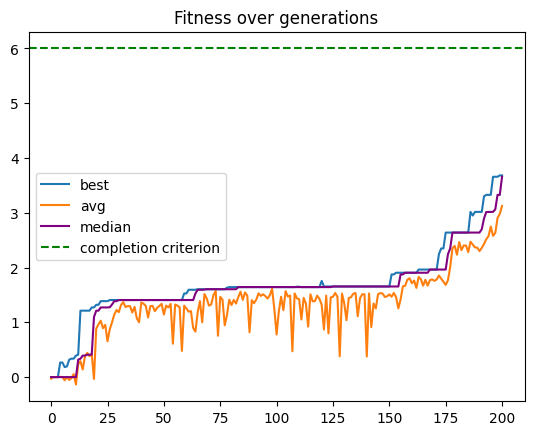

In [28]:
# Plot stats
bests = []
avgs = []
stds = []
medians = []
for stat in log:
    bests.append(stat['best'])
    avgs.append(stat['avg'])
    stds.append(stat['std'])
    medians.append(stat['median'])

utils.plot_data(bests, avgs = avgs, medians = medians, 
                completion_fitness=env.n_task * (environment.REWARD_PICK + environment.REWARD_DROP))

In [29]:
calculate_fitness(hof[0], verbose=True)


Step 0
Action:  [[0.5 5.4]
 [0.5 5.4]
 [0.5 5.4]]
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . 0 . . . . . . 1 . . . . . 2 . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . O . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . O . . . . . . . . .
. . . . . . . . O . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .

[35.94503993883664]